# Classificador de "HateSpeech"

Essa Machine Learning tem como proposito ser utilizada para identificar palavras de cunho discriminatorio, xenofobico, homofobico, machista, racista e outros tipos de palavras que venham a ter como finalidade ter o pre-conceito sobre certo assuntos ou que tem como finalidade espalhar o ódio.

## Importando o Dataset

O repositorio contém o conjunto de dados para o artigo intitulado "A Hierarchically Labeled Portuguese Hate Speech Dataset", aceito no ALW3 Workshop na ACL 2019 (Florença, Itália).

Se utilizar este conjunto de dados, cite-o:

@inproceedings{fortuna2019, title={A Hierarchically-Labeled Portuguese Hate Speech Dataset}
author={Fortuna, Paula, João Rocha da Silva, Juan Soler-Company, Leo Wanner e Sérgio Nunes}
booktitle={Proceedings of the 3rd Workshop on Abusive Language Online (ALW3)}, year={2019}

In [5]:
!pip install kaggle

In [6]:
# Não se esqueça de colocar o arquivo do Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
#Fazendo download do dataset no Kaggle
!kaggle datasets download -d hrmello/brazilian-portuguese-hatespeech-dataset

  0% 0.00/631k [00:00<?, ?B/s]
100% 631k/631k [00:00<00:00, 153MB/s]


In [8]:
#Deszipando o arquivo do dataset
from zipfile import ZipFile
file_name = 'brazilian-portuguese-hatespeech-dataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


## Import de Bibliotecas

In [9]:
#Baixando a biblioteca unidecode
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 4.4 MB/s eta 0:00:00


In [10]:
# Etc
import re

# Manipulação de Dados e graficos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding, Flatten, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp

# PLN (Processamento de Linguagem Natural) e Pré-Processamento de dados:
import nltk
import unidecode
from nltk import tokenize
from string import punctuation
from nltk import ngrams

# Deploy
import joblib

In [11]:
#Baixando Stemmer
nltk.download('rslp')
#Baixando a lista de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Codigo

In [12]:
#Carregando o dataset
df = pd.read_csv("2019-05-28_portuguese_hate_speech_binary_classification.csv")
df.head(250)

,text,hatespeech_comb,hatespeech_G1,annotator_G1,hatespeech_G2,annotator_G2,hatespeech_G3,annotator_G3
0,@__andrea__b \nO cara vive em outro mundo\nNão...,1,1,A,1.0,V,0,E
1,@_carmeloneto Estes incompetentes não cuidam n...,0,1,D,0.0,V,0,C
2,@_carmeloneto \nOs 'cumpanhero' quebraram toda...,0,1,A,0.0,B,0,E
3,@_GlitteryKisses é isso não conseguem pensar n...,0,0,C,0.0,V,0,D
4,@_iglira bom dia macaco branco haha,1,0,A,1.0,I,1,E
...,...,...,...,...,...,...,...,...
245,A intoxicação e mariquice mental da ditadura d...,0,1,B,0.0,B,0,D
246,Ai q gostoso a Cléo Pires fumando um e publica...,0,1,C,0.0,I,0,C
247,ai que saudade da ditadura............,1,1,E,1.0,B,0,E
248,ai socorro jesus deixa essa mulher no programa...,0,0,B,1.0,V,0,C


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5670 entries, 0 to 5669
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             5670 non-null   object 
 1   hatespeech_comb  5670 non-null   int64  
 2   hatespeech_G1    5670 non-null   int64  
 3   annotator_G1     5670 non-null   object 
 4   hatespeech_G2    5668 non-null   float64
 5   annotator_G2     5670 non-null   object 
 6   hatespeech_G3    5670 non-null   int64  
 7   annotator_G3     5670 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 354.5+ KB


In [14]:
#Obs: Hatespeechs são "classsificações" que foram feitas identificando se a frase é ruim ou não. Foram feitas classificações de diferentes formas, que resultaram em diferentes resultados.
#Sendo o primeiro uma possivel combinação dos resultados das outras classificações.É possivel utilizar qualquer um dos hatespeechs para usar como treinamento.
#Utilizarei o "hatespeech_G1" para esse modelo.

#Vendo o balanceamento entre 0 e 1
df['hatespeech_comb'].value_counts()

0    3882
1    1788
Name: hatespeech_comb, dtype: int64

In [15]:
df['hatespeech_G1'].value_counts()

1    3310
0    2360
Name: hatespeech_G1, dtype: int64

In [16]:
df['hatespeech_G2'].value_counts()

0.0    3928
1.0    1740
Name: hatespeech_G2, dtype: int64

In [17]:
df['hatespeech_G3'].value_counts()

0    4713
1     957
Name: hatespeech_G3, dtype: int64

In [18]:
#Retirando @, #, numeros, sequencia de caracteres repetidos e links dos tweets

def remover_links(texto):
    regex_links = r'https://t\.co/\S+'
    return re.sub(regex_links, '', texto)
df['text'] = df['text'].apply(remover_links)
print('Exemplo de Link: ', df['text'][70], '\n')

def remover_mais_links(texto):
    regex_links2 = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|www(?:[-a-zA-Z0-9]+\\.)+[a-zA-Z]{2,}(?:/[-a-zA-Z0-9]+)*'
    return re.sub(regex_links2, '', texto)
df['text'] = df['text'].apply(remover_mais_links)
print("Exemplo de Link2: ", df['text'][0], "\n")

def remover_arroba_texto(texto):
    regex_arroba = r'@\w+'
    return re.sub(regex_arroba, '', texto)
df['text'] = df['text'].apply(remover_arroba_texto)
print("Exemplo Arroba: " ,df['text'][0], "\n")

def remover_hash_texto(texto):
    regex_hash = r'#\w+'
    return re.sub(regex_hash, '', texto)
df['text'] = df['text'].apply(remover_hash_texto)
print("Exemplo Hashtag: " ,df['text'][699], "\n")

def remover_numeros(texto):
    regex_numeros = r'\d+'
    return re.sub(regex_numeros, '', texto)
df['text'] = df['text'].apply(remover_numeros)
print("Exemplo Numeros: " ,df['text'][23], "\n")

def remover_sequencias(texto):
    regex_sequencias = r'(.)\1{2,}'
    return re.sub(regex_sequencias,'', texto)
df['text'] = df['text'].apply(remover_sequencias)
print("Exemplo Sequência: " ,df['text'][24], "\n")

def remover_caracteres_especiais(texto):
    padrao_regex = r'[!@#\$%\^&\*\(\)_\+\-=\[\]\{\};:\'",<>\./?\\|]'
    return re.sub(padrao_regex, '', texto)
df['text'] = df['text'].apply(remover_caracteres_especiais)
print("Exemplo Sequência: " ,df['text'][14])

Exemplo de Link:  ACEITE OS CHIFRES
#JoaquinResponde  

Exemplo de Link2:  @__andrea__b 
O cara vive em outro mundo
Não no mundo real
REFUGIADOS são os que vivem
Nas favelas vizinhas as suas fortalezas 

Exemplo Arroba:   
O cara vive em outro mundo
Não no mundo real
REFUGIADOS são os que vivem
Nas favelas vizinhas as suas fortalezas 

Exemplo Hashtag:  Bom dia pra quem  !   

Exemplo Numeros:  [/ :] jhu : Bom viado mais lindo
[/ :] Dj Luizinho: Bom dia sapatão mais gostoza 

Exemplo Sequência:  [ENEM] Questão :  ( ) SOMETIMES ( ) VIDA DE GADO ( ) ANA JULIA ( ) PA GANGNAM STYLE 

Exemplo Sequência:   Não deixe as lembranças e saudades te minarem Enfrente ouça músicas Essa é linda msm Conhece The Corrs


In [19]:
#Retirando os acentos da coluna "text" do dataframe
sem_acentos = [unidecode.unidecode(texto) for texto in df["text"]]
#Colocando o pré-processamento feito em uma nova coluna
df["text_2"] = sem_acentos

In [20]:
#Instanciando o tokenizador para separar as palavras da string
tokenizer = tokenize.WordPunctTokenizer()
stemmer = nltk.RSLPStemmer()

In [21]:
#Juntando acentos e stopwords em uma unica lista
stopwords = nltk.corpus.stopwords.words("portuguese")
stopwords_sem_acento =  [unidecode.unidecode(texto) for texto in stopwords]
abreviacoes=["vc","pq","tb","tbm","mt","q","bjo","bja","blz","td","flw","msm","p","cmg","pra","vcê","agd","agr","dm","ctg","dps","gnt","msg","ngm","tô","tá","tô","qdo","qnd","to","ta","rt","q","n","ai"]
for i in abreviacoes:
  stopwords_sem_acento.append(i)

In [22]:
#Pré-processamento da coluna do dataframe
frase_processada = list()
for frase in df["text_2"]:
    nova_frase = list()
    frase = frase.lower()
    palavras_texto = tokenizer.tokenize(frase)
    print(palavras_texto)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(' '.join(nova_frase))
df["text_3"] = frase_processada

A saída de streaming foi truncada nas últimas 5000 linhas.
['boitempo', 'da', 'ate', 'de', 'desconto', 'em', 'todos', 'os', 'livros', 'escritos', 'por', 'mulheres', 'via']
['bolha', 'de', 'preconceito', 'tudo', 'aquilo', 'que', 'vai', 'contra', 'a', 'agenda', 'da', 'esquerda', 'que', 'manda', 'na', 'agenda', 'feminista']
['bolsomito', 'kiridinha', 'eu', 'mesmo', 'nao', 'acredito', 'que', 'isso', 'ainda', 'ocorra', 'disse', 'o', 'deputado', 'sobre', 'a', 'desigualdade', 'salarial', 'entre', 'homens', 'e', 'mulheres']
['pt', 'e', 'psdb', 'mesma', 'bosta']
['vagabunda', 'do']
['bolsonaro', 'nao', 'ganhou', 'a', 'votacao', 'para', 'presidencia', 'da', 'camara', 'pq', 'ele', 'e', 'honesto']
['bolsonaro', 'nao', 'prega', 'a', 'volta', 'dos', 'militares', 'mas', 'sim', 'defende', 'o', 'regime', 'militar', 'e', 'rebate', 'as', 'mentiras', 'faladas', 'sobre', 'est']
['"', 'bolsonaro', 'nao', 'vencera', 'as', 'eleicoes', '"', 'afirma', 'aecio', 'neves', 'zueira', 'edition', 'ah', 'ta', 'ps', 'as

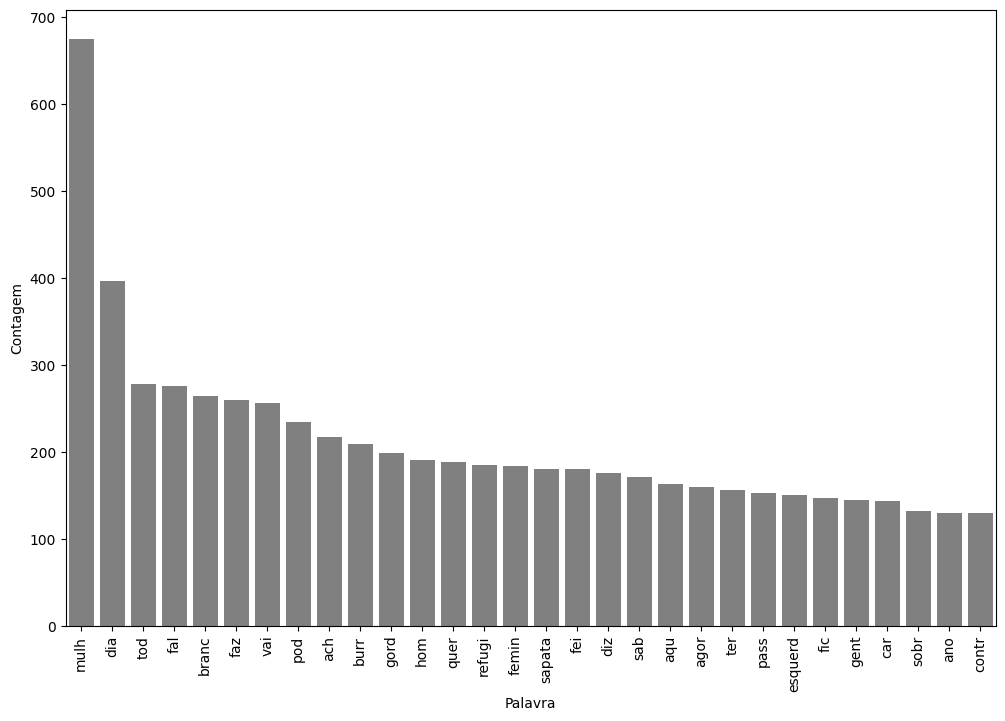

In [23]:
#Grafico com as palavras mais faladas
def pareto(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    frequencia = nltk.FreqDist(tokenizer.tokenize(todas_palavras))
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                 "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = quantidade)
    plt.figure(figsize=(12,8))
    plt.xticks(rotation=90)
    ax = sns.barplot(data = df_frequencia, x= "Palavra", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()

pareto(df, "text_3", 30)

In [24]:
#Tokenizando as palavras do dataset (transformando os textos em sequencia de numeros)
#e realizando o Padding (colocar a sequencia de numeros no mesmo comprimento)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['text_3'])
X = tokenizer.texts_to_sequences(df['text_3'])
X = pad_sequences(X)

In [25]:
#Ideia colocada de lado
#tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
#vetorizacao = tfidf.fit_transform(df["text_3"])
#vetorizacao = vetorizacao.toarray()

In [26]:
#Realizando a separação entre treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, df["hatespeech_G1"] , test_size = 0.2, random_state = 42)

In [27]:
#Modelo de Rede Neural
model = Sequential()
model.add(Embedding(40442, 32, input_length=20))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
#Realizando o fit do modelo
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
142/142 [==============================] - 31s 99ms/step - loss: 0.6737 - accuracy: 0.5871
Epoch 2/10
142/142 [==============================] - 3s 23ms/step - loss: 0.6215 - accuracy: 0.6182
Epoch 3/10
142/142 [==============================] - 3s 21ms/step - loss: 0.5312 - accuracy: 0.7180
Epoch 4/10
142/142 [==============================] - 2s 17ms/step - loss: 0.4345 - accuracy: 0.7791
Epoch 5/10
142/142 [==============================] - 1s 10ms/step - loss: 0.3470 - accuracy: 0.8111
Epoch 6/10
142/142 [==============================] - 1s 6ms/step - loss: 0.2971 - accuracy: 0.8294
Epoch 7/10
142/142 [==============================] - 1s 6ms/step - loss: 0.2620 - accuracy: 0.8404
Epoch 8/10
142/142 [==============================] - 1s 9ms/step - loss: 0.2400 - accuracy: 0.8492
Epoch 9/10
142/142 [==============================] - 1s 7ms/step - loss: 0.2265 - accuracy: 0.8556
Epoch 10/10
142/142 [==============================] - 1s 9ms/step - loss: 0.2184 - accuracy: 

## Testes para Deploy/Deploy


In [29]:
#Salvando o modelo de Rede Neural em um .pkl
joblib.dump(model, "modelo_teste_hs.pkl")

['modelo_teste_hs.pkl']

In [30]:
#Testes para realizar a predição do modelo
def pre_processamento(texto):
    lista_frase1 = list()
    lista_frase2 = list()
    tokenizer2 = tokenize.WordPunctTokenizer()
    p1 = texto.lower()
    p2 = tokenizer2.tokenize(p1)
    for i in p2:
        if i not in stopwords_sem_acento:
            lista_frase1.append(i)
    lista_frase2.append(' '.join(lista_frase1))
    return lista_frase2

In [31]:
vetorize2 = CountVectorizer(lowercase = False)

In [49]:
frase = pre_processamento("ai tem muito preto no bbb nem vo assistir kkk") #Frase retirada do dataset

In [50]:
frase_v = vetorize2.fit_transform(frase)

In [51]:
matrix_frase = pd.DataFrame.sparse.from_spmatrix(frase_v)

In [52]:
num_linhas, num_colunas = matrix_frase.shape
matriz_frase2 = sp.lil_matrix((num_linhas, 20))
matriz_frase2[:, :num_colunas] = matrix_frase
matriz_frase2 = matriz_frase2.tocsr()

In [46]:
modelo_teste = joblib.load("modelo_teste_hs.pkl")

In [53]:
teste_modelo = modelo_teste.predict(matriz_frase2)

1/1 [==============================] - 0s 35ms/step


In [54]:
teste_modelo

array([[0.4987955]], dtype=float32)

## Testes

In [39]:
total_palavras = df['text_3'].str.split().apply(len).sum()

In [40]:
total_palavras

44572

In [41]:
#Teste certo 1: 0.9268
#Teste certo 2: 0.5902
#Teste certo 3: 0.5948
#Teste certo 4: 0.9656
#Teste certo 5: 0.8609